In [1]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torch.nn as nn
from PIL import Image
from google.colab import drive

torch.manual_seed(32)
if torch.cuda.is_available():
    torch.cuda.manual_seed(32)

In [2]:
try:
    drive.mount('/content/drive')

except:
    print("You are not working in Colab at the moment :(")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!unzip -q '/content/drive/My Drive/Spore Classification/10k_split.zip' -d '/content/drive/My Drive/Spore Classification/'

In [4]:
dataset_dir = "/content/drive/My Drive/Spore Classification/10k_split"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
train_dataset = ImageFolder(root=f'{dataset_dir}/train/', transform=transform)
#test_dataset  = ImageFolder(root=f'{dataset_dir}/test/', transform=transform)
val_dataset   = ImageFolder(root=f'{dataset_dir}/val/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64,pin_memory=True, shuffle=True, num_workers=2)
#test_loader  = DataLoader(test_dataset, batch_size=32,pin_memory=True,shuffle=False, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64,pin_memory=True,shuffle=False, num_workers=2)

In [6]:


"""
full_dataset = ImageFolder(root=dataset_dir, transform=transform)
train_loader = DataLoader(full_dataset, batch_size=32,pin_memory=True, shuffle=True, num_workers=2)




# Load your dataset

full_dataset = ImageFolder(root=dataset_dir, transform=transform)

# Get the class labels
class_labels = np.array([item[1] for item in full_dataset.samples])

# Split dataset into train and test with stratification
train_indices, test_indices = train_test_split(
    np.arange(len(class_labels)),
    test_size=0.2,
    stratify=class_labels
)

# Create subsets for train and test datasets
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create DataLoaders for the subsets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2)



full_dataset = ImageFolder(root=dataset_dir, transform=transform)

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
print(train_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(
    full_dataset, [train_size, test_size])
"""

"""
trn_dir = '/content/drive/My Drive/Spore Classification/output/train/'
trn_dir = '/content/drive/My Drive/Spore Classification/output/train/'
tst_dir = '/content/drive/My Drive/Spore Classification/output/test/'

train_dataset = ImageFolder(root=trn_dir, transform=transform)
test_dataset  = ImageFolder(root=tst_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32,pin_memory=True, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32,pin_memory=True,shuffle=False, num_workers=2)
"""

"\ntrn_dir = '/content/drive/My Drive/Spore Classification/output/train/'\ntrn_dir = '/content/drive/My Drive/Spore Classification/output/train/'\ntst_dir = '/content/drive/My Drive/Spore Classification/output/test/'\n\ntrain_dataset = ImageFolder(root=trn_dir, transform=transform)\ntest_dataset  = ImageFolder(root=tst_dir, transform=transform)\n\ntrain_loader = DataLoader(train_dataset, batch_size=32,pin_memory=True, shuffle=True, num_workers=2)\ntest_loader = DataLoader(test_dataset, batch_size=32,pin_memory=True,shuffle=False, num_workers=2)\n"

In [7]:
print(len(train_loader.dataset))

1000


In [8]:
from sklearn.metrics import recall_score, f1_score

def evaluate_model(loader, model, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    val_loss = running_loss / len(loader.dataset)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return val_loss, accuracy, recall, f1

In [9]:
import matplotlib.pyplot as plt

def classify_image(image):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    image_transformed = transform(image)
    image_transformed = image_transformed.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make prediction
    with torch.no_grad():
        outputs = model(image_transformed)
        _, predicted = torch.max(outputs, 1)

    predicted_class = full_dataset.classes[predicted.item()]

    # Show the image and the predicted class
    plt.imshow(image)
    plt.title(f'Predicted class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

In [19]:
def unfreeze_layers(model, num_layers_to_unfreeze):
    print(f'Attempting to unfreeze {num_layers_to_unfreeze} layer(s).')
    layers = list(model.children())
    for i in range(num_layers_to_unfreeze):
        if i < len(layers) - 1:  # Ensure not to exceed layer count
            for param in layers[i].parameters():
                param.requires_grad = True
            print(f'Layer {i} unfrozen.')

In [16]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, len(train_dataset.classes)),
    nn.Dropout(0.5)
)

# Freeze the initial layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print()

# Initial configuration
num_initial_layers_to_freeze = 0  # Start with 10 frozen layers
unfreeze_interval = 5  # Unfreeze one layer every 5 epochs
total_layers = len(list(model.children())) - 1  # Exclude the last classification layer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
num_epochs = 50
condition = True

In [ ]:
epoch_losses = []
epoch_train_accuracies = []
epoch_val_accuracies = []
epoch_val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_preds / total_preds
    val_loss, val_accuracy, recall, f1 = evaluate_model(val_loader, model, criterion)
    scheduler.step(val_loss)

    epoch_losses.append(epoch_loss)
    epoch_train_accuracies.append(train_accuracy)
    epoch_val_losses.append(val_loss)
    epoch_val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

    if epoch % unfreeze_interval == 0 and num_initial_layers_to_freeze < total_layers:
        unfreeze_layers(model, 1)  # Unfreeze one layer
        num_initial_layers_to_freeze += 1
        print(f'Unfreezing layer {num_initial_layers_to_freeze}')

Epoch: 1, Loss: 0.2985, Train Accuracy: 0.8610, Val Loss: 0.3286, Val Accuracy: 0.8605, Recall: 0.8605, F1 Score: 0.8605
Epoch: 1, Current Frozen Layers: 10, Total Layers: 9
Epoch: 2, Loss: 0.3051, Train Accuracy: 0.8720, Val Loss: 0.3263, Val Accuracy: 0.8605, Recall: 0.8605, F1 Score: 0.8605
Epoch: 2, Current Frozen Layers: 10, Total Layers: 9
Epoch: 3, Loss: 0.3233, Train Accuracy: 0.8490, Val Loss: 0.3256, Val Accuracy: 0.8605, Recall: 0.8605, F1 Score: 0.8605
Epoch: 3, Current Frozen Layers: 10, Total Layers: 9
Epoch: 4, Loss: 0.3049, Train Accuracy: 0.8770, Val Loss: 0.3279, Val Accuracy: 0.9070, Recall: 0.9070, F1 Score: 0.9071
Epoch: 4, Current Frozen Layers: 10, Total Layers: 9
Epoch: 5, Loss: 0.3240, Train Accuracy: 0.8530, Val Loss: 0.3252, Val Accuracy: 0.8605, Recall: 0.8605, F1 Score: 0.8605
Epoch: 5, Current Frozen Layers: 10, Total Layers: 9
Epoch: 6, Loss: 0.3030, Train Accuracy: 0.8480, Val Loss: 0.3281, Val Accuracy: 0.8837, Recall: 0.8837, F1 Score: 0.8838
Epoch: 6,

In [25]:
model_save_path = 'model.pth'

torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

model.load_state_dict(torch.load(model_save_path))
model.eval()
print()

Model saved to model.pth



<ipython-input-25-8793492d7a8b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


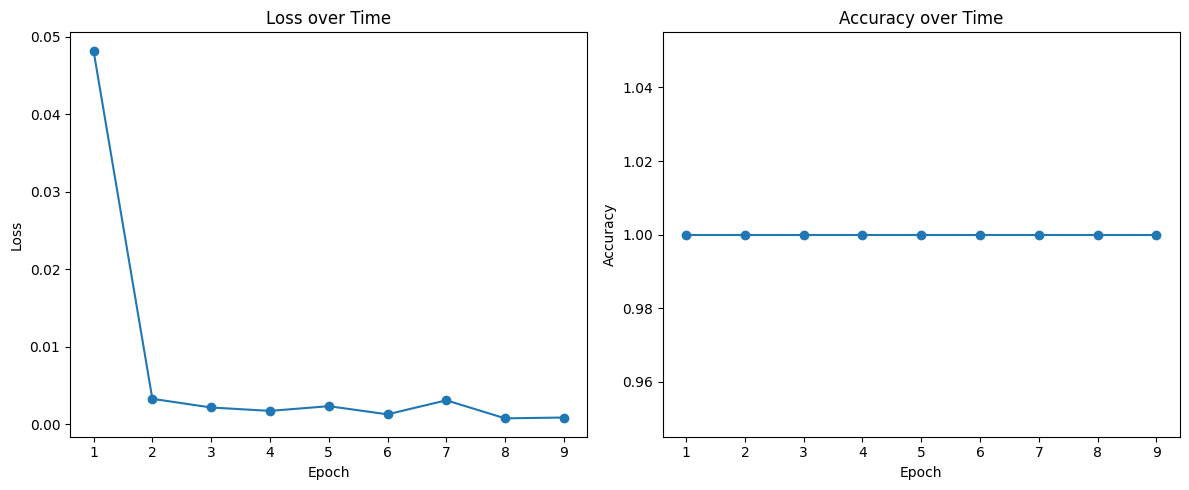

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Time')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_accuracies) + 1), epoch_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Time')

plt.tight_layout()
plt.show()

In [28]:
accuracy, recall, f1 = evaluate_model(val_loader)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

Test Accuracy: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000


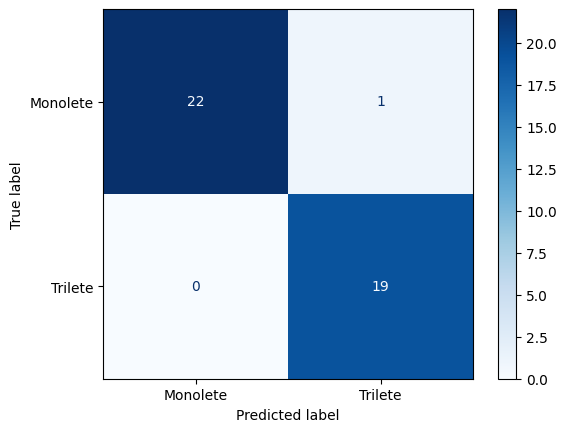

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score


all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Monolete', 'Trilete'])
disp.plot(cmap=plt.cm.Blues)

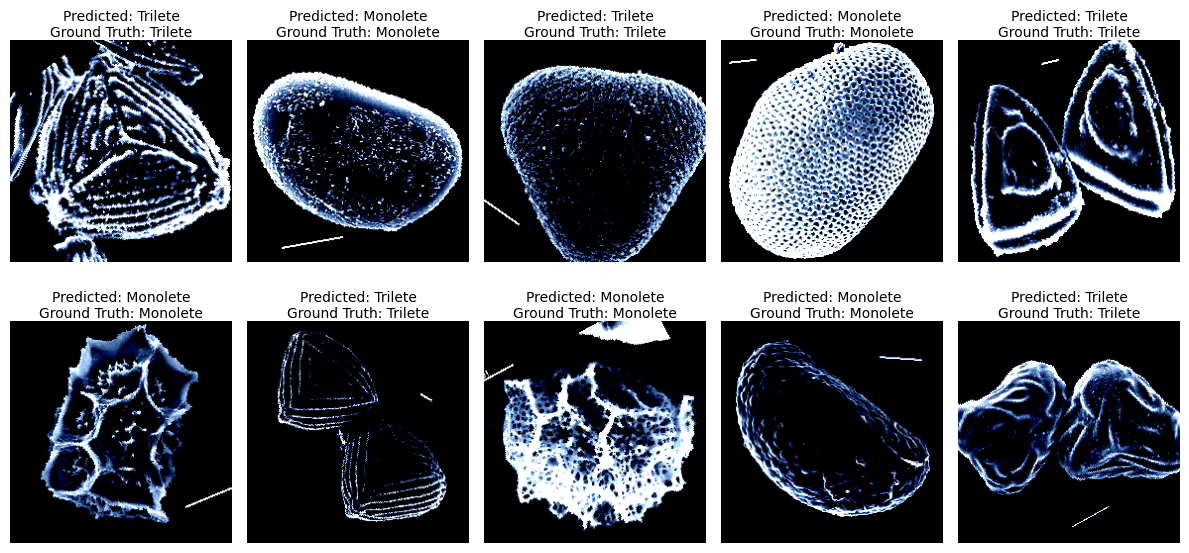

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a dictionary to decode labels
label_map = {0: 'Monolete', 1: 'Trilete'}  # Update with your actual label mapping

data_iter = iter(test_loader)
images, labels = next(data_iter)
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Plot images with their predictions
plt.figure(figsize=(12, 6))  # Increase figure size for better visibility
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
    plt.title(f'Predicted: {label_map[predicted[i].item()]}\nGround Truth: {label_map[labels[i].item()]}', fontsize=10, pad=1)
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.6)  # Adjust spacing between plots
plt.tight_layout()  # Automatically adjust subplot parameters
plt.show()

## Plot wrong predictions

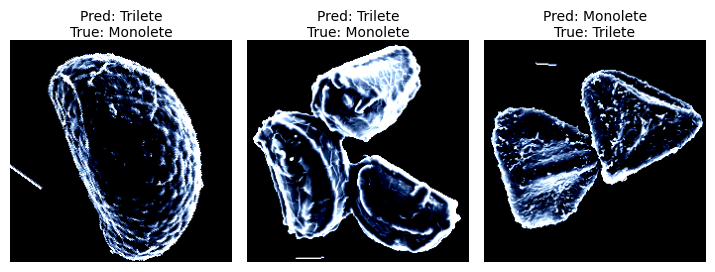

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Find incorrect predictions
incorrect_indices = [i for i in range(len(labels)) if predicted[i] != labels[i]]
incorrect_images = [images[i] for i in incorrect_indices]
incorrect_labels = [labels[i] for i in incorrect_indices]
incorrect_preds = [predicted[i] for i in incorrect_indices]

# Plot incorrect predictions
plt.figure(figsize=(12, 6))
for i in range(len(incorrect_images)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(incorrect_images[i].cpu().numpy().transpose(1, 2, 0))
    plt.title(f'Pred: {label_map[incorrect_preds[i].item()]}\nTrue: {label_map[incorrect_labels[i].item()]}', fontsize=10, pad=1)
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.tight_layout()
plt.show()

In [ ]:
from glob import glob
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    for idx, image in enumerate(images):
      classify_image(to_pil(image))

    if idx > 10:
        break
    #classify_image(images[0].unsqueeze(0))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(3, 224, 224)  # Reshape back to original dimensions
        image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for PIL
        image = Image.fromarray((image * 255).astype(np.uint8))  # Convert to PIL Image

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
def prepare_smote(data_loader):
    images = []
    labels = []
    for img, lbl in data_loader:
        images.extend(img.numpy())
        labels.extend(lbl.numpy())
    images = np.array(images).reshape(len(images), -1)  # Flatten images
    labels = np.array(labels)
    return images, labels

# Apply SMOTE to balance classes
def apply_smote(images, labels):
    smote = SMOTE()
    resampled_images, resampled_labels = smote.fit_resample(images, labels)
    return resampled_images, resampled_labels

# Convert flattened images back to the original shape
def reshape_images(images, img_shape):
    return images.reshape(len(images), *img_shape)

In [ ]:
original_loader = DataLoader(full_dataset, batch_size=32, shuffle=True, num_workers=12, pin_memory=True)
images, labels = prepare_smote(original_loader)

In [ ]:
from imblearn.over_sampling import SMOTE

resampled_images, resampled_labels = apply_smote(images, labels)
resampled_images = reshape_images(resampled_images, (3, 224, 224))

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset (80% training, 20% testing)
train_images, test_images, train_labels, test_labels = train_test_split(
    resampled_images, resampled_labels, test_size=0.2, random_state=42
)

train_dataset = CustomImageDataset(train_images, train_labels, transform=transform)
test_dataset = CustomImageDataset(test_images, test_labels, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)
print(len(train_loader.dataset))
print(len(test_loader.dataset))

In [ ]:
#while condition:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    accuracy = evaluate_model(test_loader)
    print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Test Acc: {accuracy:.4f}')
 #   if accuracy > 0.99:
  #      condition = False
    #num_epochs += 1


torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

model.load_state_dict(torch.load(model_save_path))
model.eval()
print()

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Change dimensions for plotting
    plt.show()

# Visualize a few resampled images
def show_smote_images(resampled_images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 12))
    for i in range(num_images):
        img = resampled_images[i]
        img = img.reshape(3, 224, 224)  # Reshape the flattened image
        img_tensor = torch.Tensor(img)  # Convert to tensor for display
        imshow(img_tensor)
        plt.axis('off')

# Assuming resampled_images is in the shape (num_images, 3*256*256)
show_smote_images(resampled_images, num_images=5)